<a href="https://colab.research.google.com/github/angelaqu129/AI-Engineering-I4/blob/main/explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Explainability with Alibi
In this lab, you'll learn about the Alibi Explain library and implement global and local explanations of tabular and image classification models.

Alibi Explain is an open source Python library aimed at machine learning model inspection and interpretation. The focus of the library is to provide high-quality implementations of black-box, white-box, local and global explanation methods for classification and regression models.

Complete all the Deliverables mentioned below and show it to a TA for credit.

## Deliverables
- Finish all the TODOs in Section 2
- Generate PD Plots. Discuss your findings about model performance with the TA and answer Q1, Q2, and Q3:
     - Q1: Which features have higher importance in the prediction? (Section 2.1)
     - Q2: What can you conclude with the PD plots? (Section 2.2)
     - Q3: Discuss with the TA the results (heatmaps). (Section 2.2)
- Show final results  about the Anchor parameters and discuss them with the TA.

## Getting Started
Clone this repository and run all cells in the notebook.

### Install Dependencies

For this assignment, make sure you have the required packages installed.
```
pip install -r requirements.txt
```
(If there are any major unsolvable issues prefer running this notebook on Google Colaboratory)

### Possible Issues with installing Alibi
`TypeError: issubclass() arg 1 must be a class` \
**Solution:** https://stackoverflow.com/questions/76313592/import-langchain-error-typeerror-issubclass-arg-1-must-be-a-class
<br><br>
If there's any more issues, please contact a TA to update this list (with a solution if its solved)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! pip install -r requirements.txt
!pip install -r /content/drive/MyDrive/mlip-explainability-lab/requirements.txt


In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4


In [ ]:
!pip install numpy==1.25.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 36.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.6 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.14.1 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.14.1 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, 

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd, plot_pd_variance
from alibi.explainers import PartialDependenceVariance


## Section 1 - Data + Modeling
In this section, we will be setting up our data, perform some preprocessing and train a model.

### 1.1 Fetching the Dataset
We are going to use the The Boston Housing Dataset in the next experiment.
https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html


There are 14 attributes in each case of the dataset:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

In [ ]:
# df = pd.read_csv('BostonHousing.csv')

df = pd.read_csv('/content/drive/MyDrive/mlip-explainability-lab/BostonHousing.csv')
df.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### 1.2 Dataset Preprocessing

Run the following code necessary to pre-process the data for alibi.

In [ ]:
# extract feature names
feature_names = df.columns.tolist()
target_feature = 'medv'
feature_names.remove(target_feature)

# define target names
target_names = [target_feature]

#  define categorical columns
categorical_columns_names = []

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
# define target column
y = df[target_feature]

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [ ]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)


In [ ]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### 1.3 Training the Model
Run the cell to fit the model to the dataset

In [ ]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.98
Test score: 0.77


## Section 2 - Explainability with Alibi
In this section, we will be finally using Alibi to explain our trained model using different techniques. Fill in the TODOs and generate plots where required.

In [ ]:
# Creating a Prediction Function - Includes pipeline from preprocessing to prediction
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

#### Computing Explanations
We will finally be computing explanations for selected features. Play around with different methods.

### 2.1 Partial Dependence Variance (PDV)  - Feature Importance

Partial Dependence Variance is a method to compute the global feature importance or the feature interaction of a pair of features.

Complete the code below and answer Q1

**Q1: Which features have higher importance in the prediction?**

array([[<Axes: title={'center': 'imp(lstat) = 3.887'}, xlabel='lstat', ylabel='c_0'>,
        <Axes: title={'center': 'imp(rm) = 3.512'}, xlabel='rm', ylabel='c_0'>,
        <Axes: title={'center': 'imp(dis) = 0.899'}, xlabel='dis', ylabel='c_0'>],
       [<Axes: title={'center': 'imp(ptratio) = 0.510'}, xlabel='ptratio', ylabel='c_0'>,
        <Axes: title={'center': 'imp(nox) = 0.334'}, xlabel='nox', ylabel='c_0'>,
        <Axes: title={'center': 'imp(age) = 0.322'}, xlabel='age', ylabel='c_0'>],
       [<Axes: title={'center': 'imp(crim) = 0.320'}, xlabel='crim', ylabel='c_0'>,
        <Axes: title={'center': 'imp(indus) = 0.265'}, xlabel='indus', ylabel='c_0'>,
        <Axes: title={'center': 'imp(b) = 0.219'}, xlabel='b', ylabel='c_0'>],
       [<Axes: title={'center': 'imp(tax) = 0.110'}, xlabel='tax', ylabel='c_0'>,
        <Axes: title={'center': 'imp(chas) = 0.046'}, xlabel='chas', ylabel='c_0'>,
        <Axes: title={'center': 'imp(rad) = 0.032'}, xlabel='rad', ylabel='c_0'>]

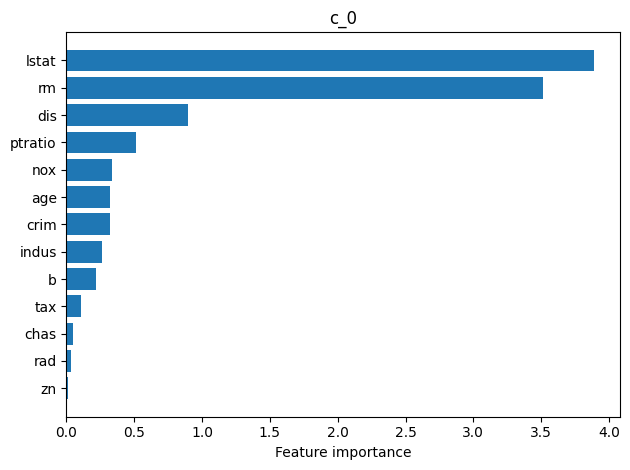

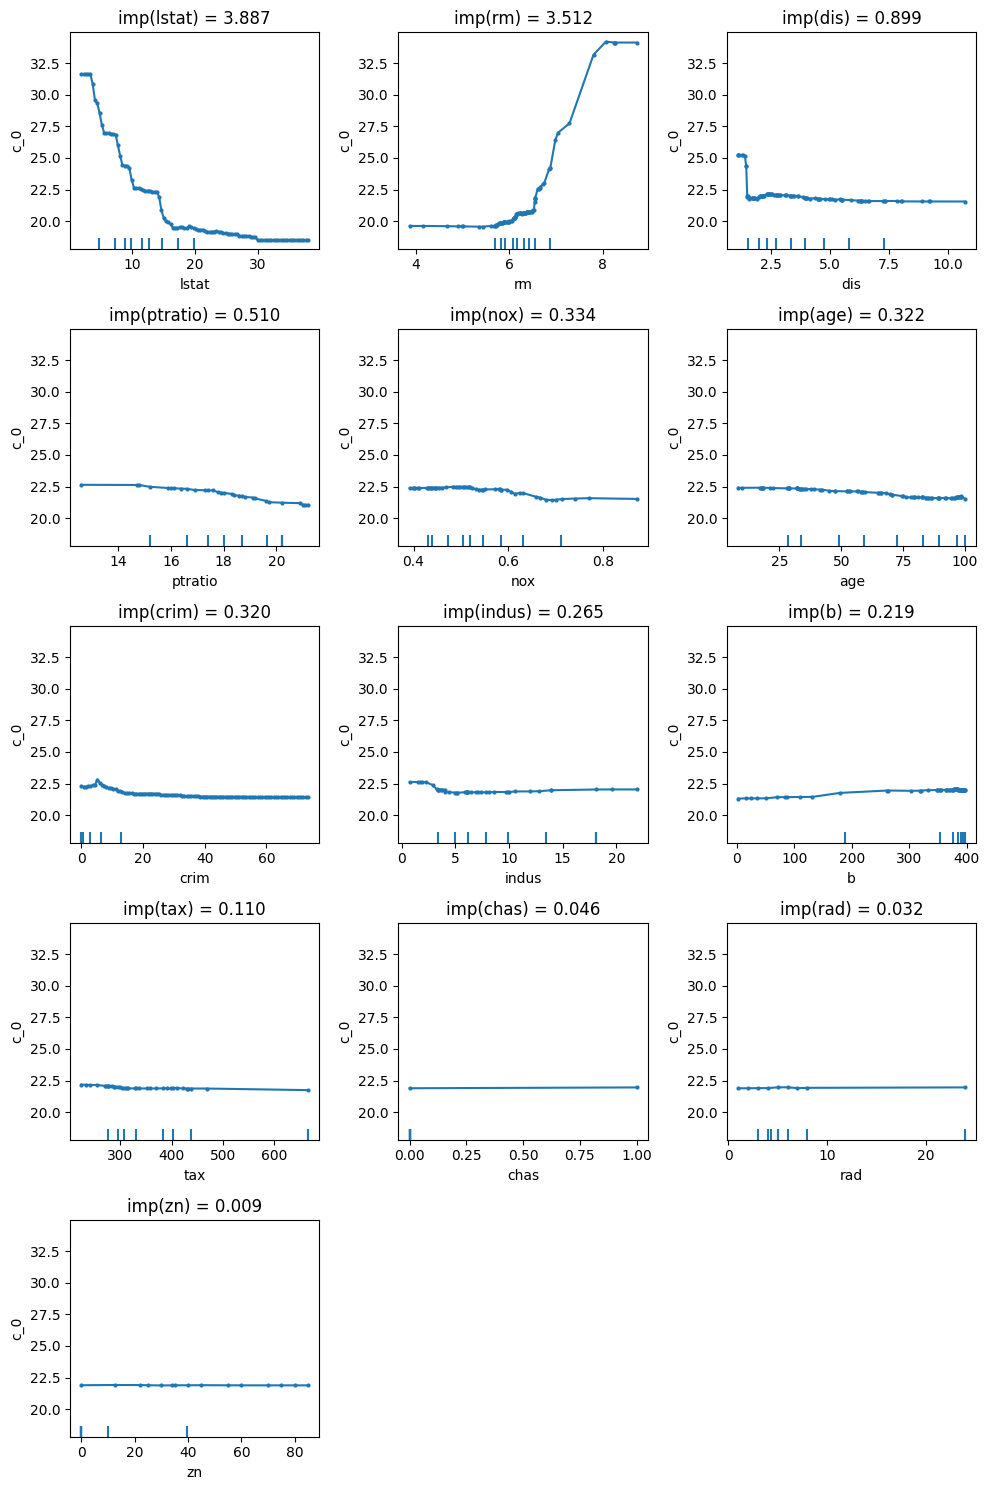

In [ ]:
# TODO: Determine which features are more important
# suggestion: Use PartialDependenceVariance class and explain function using the argument method='importance'

#explainer = ...
#exp_importance = ...
explainer = PartialDependenceVariance(
    predictor=prediction_fn,
    feature_names=feature_names,
    categorical_names=categorical_names
)
exp_importance = explainer.explain(
    X=X_test,
    method='importance'
)

# plot the results using
plot_pd_variance(exp=exp_importance)
plot_pd_variance(exp=exp_importance, summarise=False,  fig_kw={'figheight': 15, 'figwidth': 10})



### 2.2 Partial Dependence (PD)

Partial Dependence is a method to visualize the marginal effect that one or two features have on the predicted outcome of a machine learning model.

By inspecting the PD plots, one can understand whether the relation between a feature/pair of features is, for example, a simple linear or quadratic relation, whether it presents a monotonically increasing or decreasing trend, or reveal a more complex response.

#### Computing Explanations
We will finally be computing explanations. You can try different modes of `kind` to see different visualizations. (Suggestion: use `both` to visualize all data)

As per the documentation,
> `kind` - If set to `average`, then only the partial dependence (PD) averaged across all samples from the dataset is returned. If set to `individual`, then only the individual conditional expectation (ICE) is returned for each individual from the dataset. Otherwise, if set to `both`, then both the PD and the ICE are returned.


Run the following code with all features and also selecting some specific features.

**Q2: What can you conclude?**

In [ ]:
# Define explainer
explainer_pd = PartialDependence(predictor=prediction_fn,
                       feature_names=feature_names,
                       categorical_names=categorical_names,
                       target_names=target_names)


In [ ]:
# you can also compute explanations for selected features.
# Hint - Select Column Indices = feature_names.index("COLUMN_NAME")
# zn	indus	chas	nox	rm	age	dis	rad	tax	ptratio	b	lstat	medv

# TODO - Select features you wish to compute explanations for
# Hint - Select Column Indices = feature_names.index("COLUMN_NAME")

# features = list(range(len(feature_names)))
features = [
    feature_names.index('lstat'),
    feature_names.index('rm'),
    feature_names.index('ptratio')
]


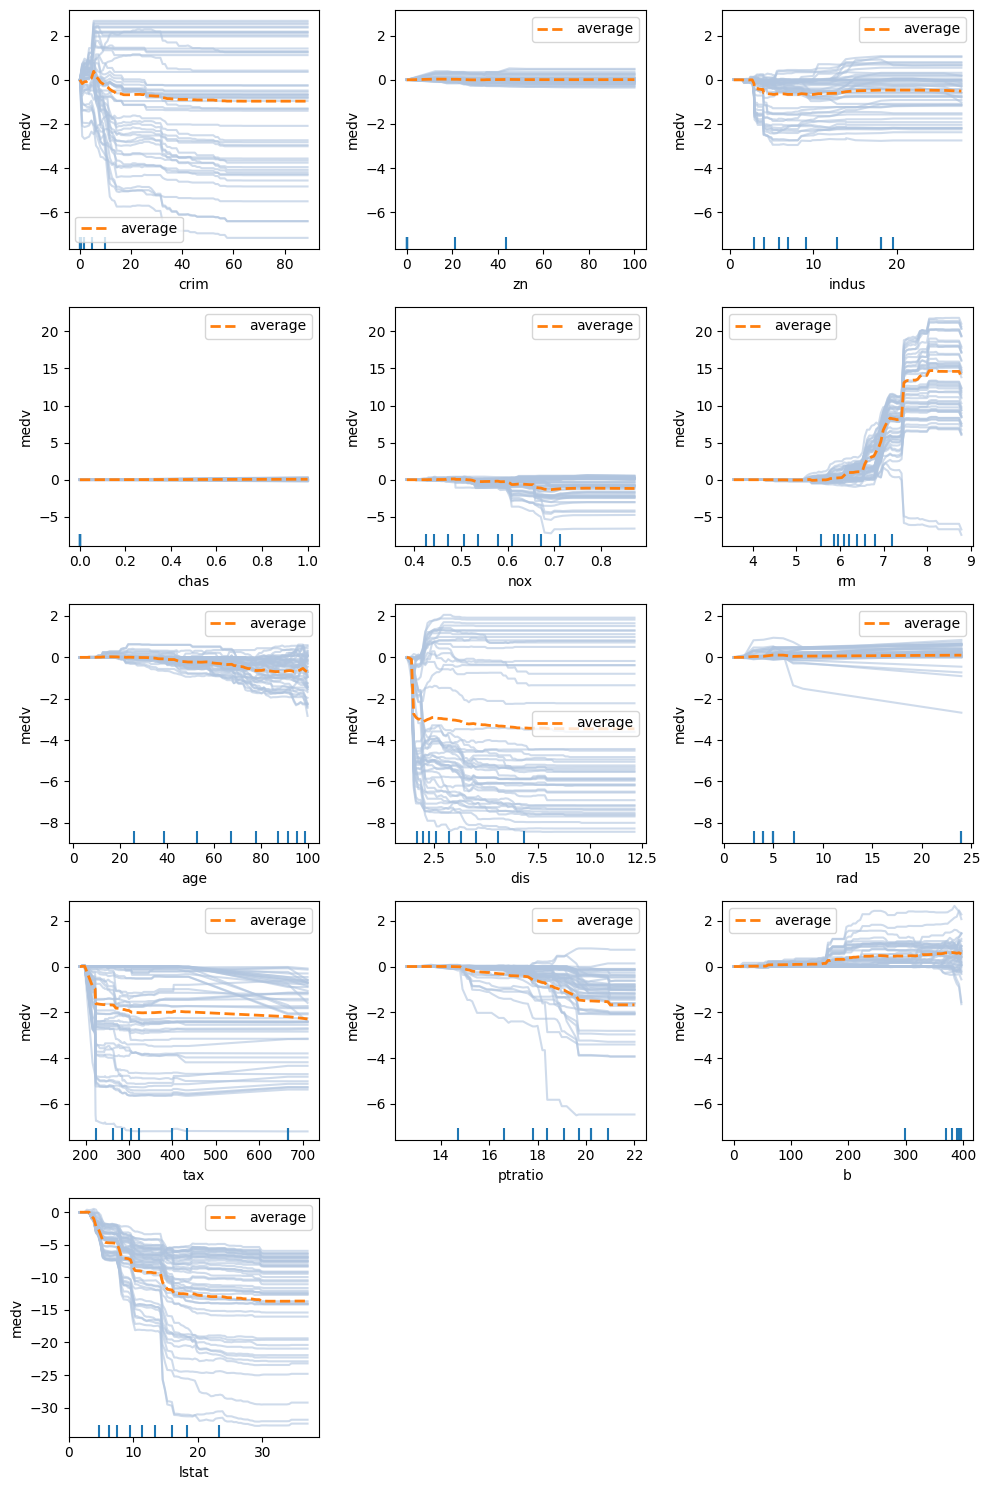

In [ ]:
# compute explanations
exp = explainer_pd.explain(X=X_train,
                        #features=features,
                        kind='both') # kind = [both, individual, average]

# plot partial dependece curves
# this setup should work for any mode of kind, feel free to alter this to better suit your plot view.
plot_pd(exp=exp,
        n_cols=3,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 15, 'figwidth': 10});


### Check Partial Dependence for Two Features
Choose pairs of features to visualize their relationships and interactions with each other. These plots may be a bit confusing so try your best to explain whatever you understand to the TA.
We suggest to select a feature with high  and low importance.
You can also try different combinations of features in order to get better conclusion.

**Q3: Discuss with the TA the results.**

In [ ]:
# TODO: select combination of features
FEATURE1 = 'lstat'
FEATURE2 = 'rad'

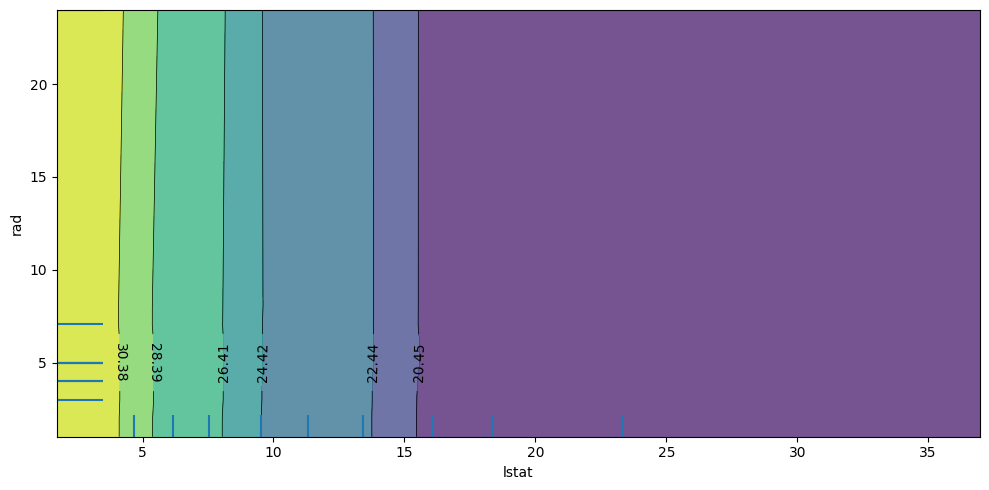

In [ ]:
combined_features = [(feature_names.index(FEATURE1), feature_names.index(FEATURE2))]

# compute explanations
comb_exp = explainer_pd.explain(X=X_train,
                        features=combined_features,
                        kind='average',
                        grid_resolution=25) # kind = [both, individual, average]

# plot partial dependece curves
plot_pd(exp=comb_exp,
        n_cols=3,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 5, 'figwidth': 10});


## 2.3 Anchors
This algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Run all the cells and try different parameters to see how this algorithm works.

We will be explaining predictions from the ImageNet model on the cats dataset.

In [ ]:
import tensorflow as tf
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
image_shape = (299, 299, 3)
data, labels = load_cats(target_size=image_shape[:2], return_X_y=True)
print(f'Images shape: {data.shape}')

Images shape: (4, 299, 299, 3)


In [ ]:
images = preprocess_input(data)
preds = model.predict(images)
label = decode_predictions(preds, top=3)
print(label[0])

35363/35363 [==============================] - 0s 0us/step
[('n02123045', 'tabby', 0.8208685), ('n02123159', 'tiger_cat', 0.14372924), ('n02124075', 'Egyptian_cat', 0.016421808)]


In [ ]:
# Define prediction function
predict_fn = lambda x: model.predict(x)

In [ ]:
#TODO:play around with parameters
segmentation_fn = 'slic' # choose from different segmentation functions - https://scikit-image.org/docs/dev/api/skimage.segmentation.html
# segmentation_fn = 'quickshift'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5, 'start_label': 0} #
# kwargs = {
#     'n_segments': 50,
#     'compactness': 30,
#     'sigma': 1.0,
#     'start_label': 0
# }

explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

1/1 [==============================] - 1s 509ms/step


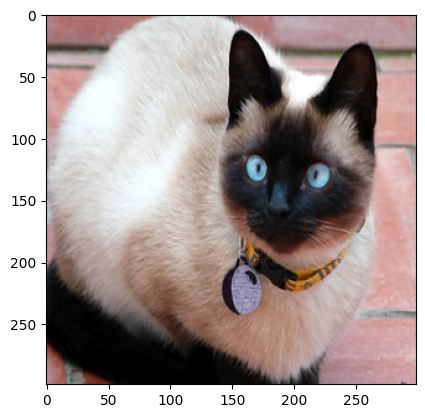

In [ ]:
i = 2 # you can change i to choose another picture
plt.imshow(data[i])
plt.show()

In [ ]:
image = images[i]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25) # play around with parameters

4/4 [==============================] - 33s 9s/step


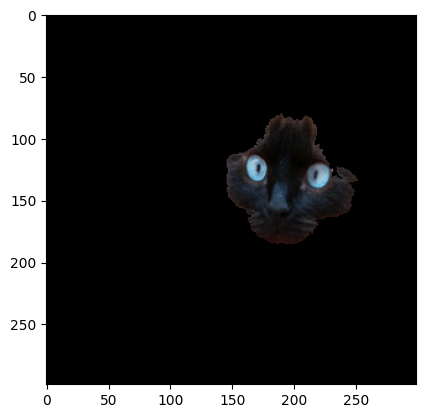

In [ ]:
plt.imshow(explanation.anchor);

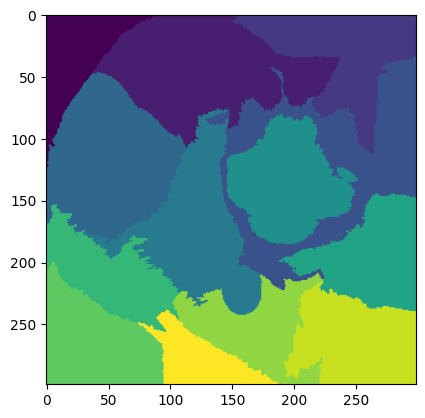

In [ ]:
plt.imshow(explanation.segments);

### References
1. https://docs.seldon.io/projects/alibi/en/stable/examples/pdp_regression_bike.html
2. https://docs.seldon.io/projects/alibi/en/stable/methods/PartialDependence.html
3. https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html
